In [ ]:
# Install necessary libraries (if not already installed)
# These commands are commented out because they are typically run once in the environment.
# !pip install kaggle
# !pip install kagglehub

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install Pillow
# !pip install scikit-learn

# !pip install seaborn

# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install torchsummary

# !pip install joblib

# Setup

In [ ]:
# Copy from kaggle
import kagglehub

# Download the latest version of the Pokémon classification dataset from Kaggle
org_path = kagglehub.dataset_download("lantian773030/pokemonclassification")

print("Path to dataset files:", org_path)


Path to dataset files: C:\Users\CindyHong\.cache\kagglehub\datasets\lantian773030\pokemonclassification\versions\1


In [ ]:
# Import standard libraries for data manipulation and visualization
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import ImageOps,ImageEnhance
import seaborn as sns

# Import machine learning models and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Import PyTorch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split
import scipy

from torchvision import models
from sklearn.utils.class_weight import compute_class_weight

from joblib import dump, load
import gc


In [ ]:
# Set random seed for reproducibility
np.random.seed(2024)

In [5]:
# Setting dataset path
path = os.path.join(org_path,'PokemonData')
path

'C:\\Users\\CindyHong\\.cache\\kagglehub\\datasets\\lantian773030\\pokemonclassification\\versions\\1\\PokemonData'

In [ ]:
# Load the class labels from the CSV file
class_list = pd.read_csv('class_sheet.csv')

In [ ]:
# Identify classes with bad data
bad_class_list = class_list[class_list['Bad_Data'] == 1]['Pokemon']
bad_image_paths = []
valid_extensions = ['.jpg', '.jpeg', '.png']

In [8]:
# Removing all classes with bad data
class_list = class_list[class_list['Bad_Data'] != 1]

In [ ]:
# Get Pokemons that are winged and not winged
winged = class_list[class_list['Winged'] == 1]
winged = winged['Pokemon']
not_winged = class_list[class_list['Not_Winged'] == 1]
not_winged = not_winged['Pokemon']

In [ ]:
# Make data frame that has the image arrays and their classifcation
images = []

# Process images of winged Pokémon
for folder in winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            continue
        image_path = os.path.join(path,folder,image)
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Winged'})
        #Release memory
        del img
        gc.collect()

# Process images of not winged Pokémon          
for folder in not_winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            continue
        image_path = os.path.join(path,folder,image)
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Not Winged'})
        
        # Release memory
        del img
        gc.collect()

# Create a DataFrame from the list of images and their labels           
df = pd.DataFrame(images)
# set(wrong_extensions)

In [11]:
# Sanity check to make sure there are only 2 classes
for index, row in df.iterrows():
    if row['Source'] not in ['Winged', 'Not Winged']:
        print(row)

# Data Preprocessing

In [ ]:
# Normalizing function
def zscore(img,default = False):
    '''
        Apply Z-score normalization to an image.

    Parameters:
    - img (numpy array): The input image array.
    - default (bool): Whether to use default ImageNet mean and std.

    Returns:
    - img (numpy array): The normalized image array.
    '''
    img = img.astype(np.float32)
    for c in range(img.shape[2]):
        if not default:
            mean = img[:,:,c].mean()
            std = img[:,:,c].std()
        else:
            # Use default mean and std from ImageNet
            mean=[0.485, 0.456, 0.406][c]
            std=[0.229, 0.224, 0.225][c]
        if std > 0:
            img[:,:,c] = (img[:,:,c] - mean) / std
        else:
            img[:,:,c] = (img[:,:,c] - mean)
    return img

def minmax(img):
    '''
    Apply Min-Max normalization to an image.

    Parameters:
    - img (numpy array): The input image array.

    Returns:
    - img (numpy array): The normalized image array.
    '''
    img = img.astype(np.float32)
    for c in range(img.shape[2]):
        max = img[:,:,c].max()
        min = img[:,:,c].min()
        img[:,:,c] = (img[:,:,c] - min) / (max - min)
    return img

In [ ]:
# Function to preprocess images
def preprocess(df, pattern, default=False, batch_size=50):
    '''
    Preprocess images by resizing, converting to grayscale or RGB, and normalizing pixel values.

    Parameters:
    - df (DataFrame): DataFrame containing images and labels.
    - pattern (str): Normalization pattern ('Zscore', 'Minmax', 'Grayscale').
    - default (bool): Whether to use default mean and std for Z-score normalization.
    - batch_size (int): Number of images to process in each batch.

    Returns:
    - X (numpy array): Array of preprocessed images.
    - y (numpy array): Array of corresponding labels.
    '''

    X = []
    y = []
    new_size = (224, 224)

     # Process images in batches to manage memory usage
    for start in range(0, len(df), batch_size):
        batch_df = df.iloc[start:start + batch_size]
        X_batch = []
        y_batch = []
        for _, row in batch_df.iterrows():
            # Resize images to 224 x 224
            img = Image.fromarray(row['Image']).resize(new_size)
            if pattern == 'Grayscale':
                # Convert images to grayscale
                img = img.convert('L')
                img = np.array(img) / 255.0
            else:
                img = img.convert('RGB')
                img = np.array(img)
                # Zscore normalization
                if pattern == 'Zscore':
                    img = zscore(img, default=default)
                # Minmax normalization
                elif pattern == 'Minmax':
                    img = minmax(img)

            X_batch.append(img)
            y_batch.append(1 if row['Source'] == 'Winged' else 0)
        
        X.append(np.array(X_batch))
        y.append(np.array(y_batch))
        
        # Release memory
        del X_batch, y_batch
        gc.collect()
    
    # Concatenate batches into full arrays
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y # X shape: (n_samples, 224, 224, 3) or (n_samples, 224, 224)

In [ ]:
# Choose normalization pattern and preprocess images
pattern = 'Zscore'
X,y = preprocess(df[:50],pattern)
X.shape

(50, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

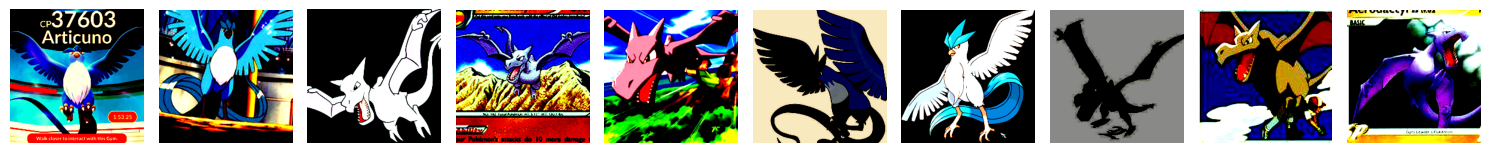

In [ ]:
# Plotting 10 images after Zscore normalization
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [ ]:
# Repeat the preprocessing with Min-Max normalization
pattern = 'Minmax'
X,y = preprocess(df[:50],pattern)
X.shape

(50, 224, 224, 3)

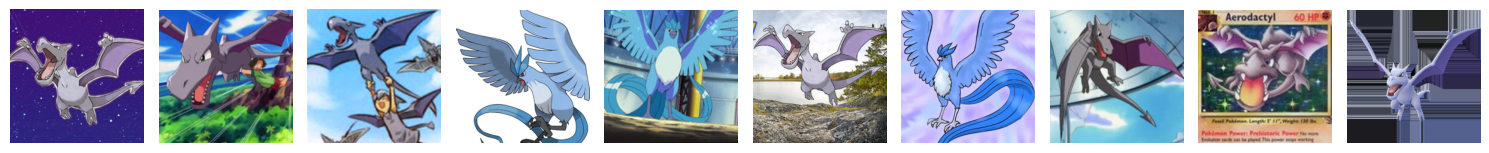

In [ ]:
# Plotting 10 images after Min-Max normalization
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [ ]:
# Repeat the preprocessing with Grayscale conversion
pattern = 'Grayscale'
X,y = preprocess(df[:50],pattern)
X.shape

(50, 224, 224)

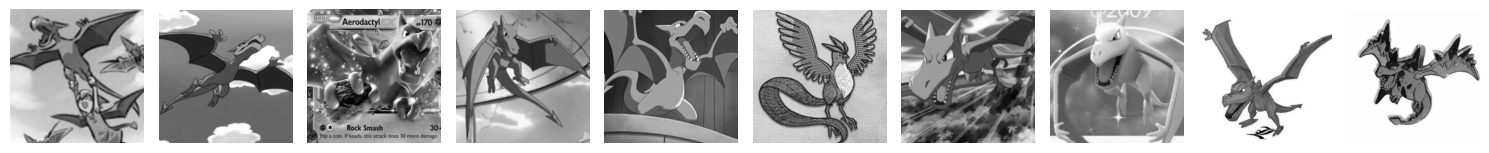

In [25]:
# Plotting 10 images after Grayscale
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img,cmap="gray") 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [ ]:
######## We can also use some optimization methods to train on imbalanced dataset ########
# Balancing the data set by random sampling
def random_sample(X,y,size=600):
    '''
    Balance the dataset by randomly sampling equal numbers of images from each class.

    Parameters:
    - X (numpy array): Array of images.
    - y (numpy array): Array of labels.

    Returns:
    - X (numpy array): Balanced array of images.
    - y (numpy array): Balanced array of labels.
    '''
    id_not_winged = np.where(y == 0)[0]
    id_winged = np.where(y == 1)[0]
    sample_not_winged = np.random.choice(id_not_winged, size, replace=False)
    sample_winged = np.random.choice(id_winged, size, replace=False)
    sample = np.concatenate((sample_not_winged, sample_winged), axis=0)
    X = X[sample]
    y = y[sample]
    return X,y
######## We can also use some optimization methods to train on imbalanced dataset ########

# Creating Train/Validate/Test splits (80/10/10)
def random_split(X,y):
    '''
    Split the data into training, validation, and test sets (80% train, 10% val, 10% test).

    Parameters:
    - X (numpy array): Array of images.
    - y (numpy array): Array of labels.

    Returns:
    - X_train, X_val, X_test: Split arrays of images.
    - y_train, y_val, y_test: Split arrays of labels.
    '''
    #Split into training and temporary sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=2024, stratify=y)

    #Split the temporary set into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2024, stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val,y_test

# X , y = random_sample(X,y)
# X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)

In [ ]:
# Augmentation function
# Our resized image doesn't have enough space for shearing or zooming
def augmentation(img,pattern,img_size=(224,224),horizontal_flip=True,vertical_flip=False,rotation_range=20, horizontal_shift=0.2, vertical_shift=0.2):
    '''
    Apply data augmentation techniques to a single image.

    Parameters:
    - img (numpy array): Input image.
    - pattern (str): Normalization pattern used ('Zscore', 'Minmax', 'Grayscale').
    - img_size (tuple): Desired output image size.
    - horizontal_flip (bool): Whether to apply horizontal flip.
    - vertical_flip (bool): Whether to apply vertical flip.
    - rotation_range (int): Range of degrees for random rotations.
    - horizontal_shift (float): Fraction of width for horizontal shift.
    - vertical_shift (float): Fraction of height for vertical shift.

    Returns:
    - img (numpy array): Augmented image.
    '''
    if img.dtype == np.float32:
        # Convert image back to uint8 for PIL processing
        img = (img * 255).astype(np.uint8)
    if pattern != 'Grayscale':
        # Calculate mean pixel value for fill color
        mean = tuple(np.mean(img,axis=(0,1)).astype(int))
    else:
        mean = 0
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)

    # Apply horizontal flip with 50% probability
    if horizontal_flip and np.random.random() < 0.5:
        img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

    # Apply vertical flip with 50% probability
    if vertical_flip and np.random.random() < 0.5:
        img = img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)

    # Apply random rotation within the specified range
    if rotation_range > 0:
        rotation_range = np.random.randint(-rotation_range, rotation_range)
        img = img.rotate(rotation_range, resample=Image.BICUBIC,fillcolor=mean)

    # Apply random shifts
    if horizontal_shift > 0 or vertical_shift > 0:
        w , h = img_size
        dw = np.random.randint(-horizontal_shift * w, horizontal_shift * w)
        dh = np.random.randint(-vertical_shift * h, vertical_shift * h)
        img = ImageOps.expand(img, border=(abs(dw),abs(dh),abs(dw),abs(dh)),fill=mean)
        img = img.crop((dw+abs(dw),dh+abs(dh),dw+abs(dw)+w,dh+abs(dh)+h))
    # Ensure the image is resized back to the original dimensions
    img = img.resize(img_size)

    # Convert image back to numpy array and normalize pixel values
    img = np.array(img).astype(np.float32) / 255.0
    return img

In [ ]:
# Going through all images and augment them
def augment_loop(X_train,y_train,pattern,img_size=(224,224),horizontal_flip=True,vertical_flip=False,rotation_range=20, horizontal_shift=0.2, vertical_shift=0.2):
    
    '''
    Apply augmentation to the training dataset.

    Parameters:
    - X_train (numpy array): Training images.
    - y_train (numpy array): Training labels.
    - pattern (str): Normalization pattern used.
    - img_size (tuple): Desired output image size.
    - Other parameters: Augmentation options.

    Returns:
    - X_train (numpy array): Augmented training images.
    - y_train (numpy array): Corresponding labels.
    '''
    
    X_augmented = []
    y_augmented = []
    for img, label in zip(X_train,y_train):
        X_augmented.append(img) # Original image
        img = augmentation(img,pattern,img_size,horizontal_flip,vertical_flip,rotation_range, horizontal_shift, vertical_shift)
        X_augmented.append(img) # Augmented image
        y_augmented.append(label)
        y_augmented.append(label)
    X_train = np.array(X_augmented)
    y_train = np.array(y_augmented)
    return X_train, y_train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


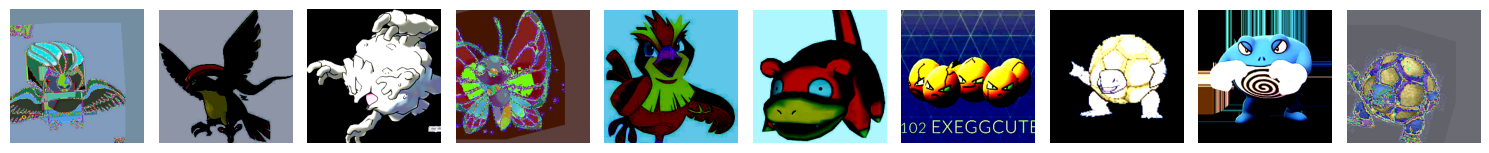

In [29]:
# Plotting 10 images after augmenting
pattern = 'Zscore'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y,size=10)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)
X_random_id = np.random.choice(X_train.shape[0], 10, replace=False)
X_random = X_train[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [ ]:
# Check shapes of training, validation, and test sets
X_train.shape, X_val.shape, X_test.shape

((32, 224, 224, 3), (2, 224, 224, 3), (2, 224, 224, 3))

# Model Training

## ML

### Data Visualization

In [ ]:
# Print classification report and Plot confusion matrix
def report_cm(model,X_train,y_train,X_val,y_val,X_test,y_test):

    '''
    Evaluate a machine learning model and plot confusion matrices.

    Parameters:
    - model: Trained machine learning model.
    - X_train, y_train: Training data and labels.
    - X_val, y_val: Validation data and labels.
    - X_test, y_test: Test data and labels.
    '''

    # Predictions on training data
    y_train_pred = model.predict(X_train)
    print(classification_report(y_train,y_train_pred))
    cm_train = confusion_matrix(y_train,y_train_pred)
    
    # Predictions on validation data
    y_val_pred = model.predict(X_val)
    print(classification_report(y_val,y_val_pred))
    cm_val = confusion_matrix(y_val,y_val_pred)
    
    # Predictions on test data
    y_test_pred = model.predict(X_test)
    print(classification_report(y_test,y_test_pred))
    cm_test = confusion_matrix(y_test,y_test_pred)
    
    # Plot confusion matrices
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Train')
    plt.subplot(1, 3, 2)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Val')
    plt.subplot(1, 3, 3)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Test')
    plt.show()


### Logistic Regression

In [ ]:
# Preprocess data using Min-Max normalization
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [33]:
X_train.shape

(1920, 224, 224, 3)

In [ ]:
# Flatten images for logistic regression
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# Train logistic regression model
LR = LogisticRegression(max_iter=1000)
LR.fit(X_flattened_train, y_train)
dump(LR, 'LR.joblib')

['LR.joblib']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       960

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920

              precision    recall  f1-score   support

           0       0.59      0.67      0.62        60
           1       0.62      0.53      0.57        60

    accuracy                           0.60       120
   macro avg       0.60      0.60      0.60       120
weighted avg       0.60      0.60      0.60       120

              precision    recall  f1-score   support

           0       0.61      0.68      0.65        60
           1       0.64      0.57      0.60        60

    accuracy                           0.62       120
   macro avg       0.63      0.62      0.62       120
weighted avg       0.63      0.62      0.62       120



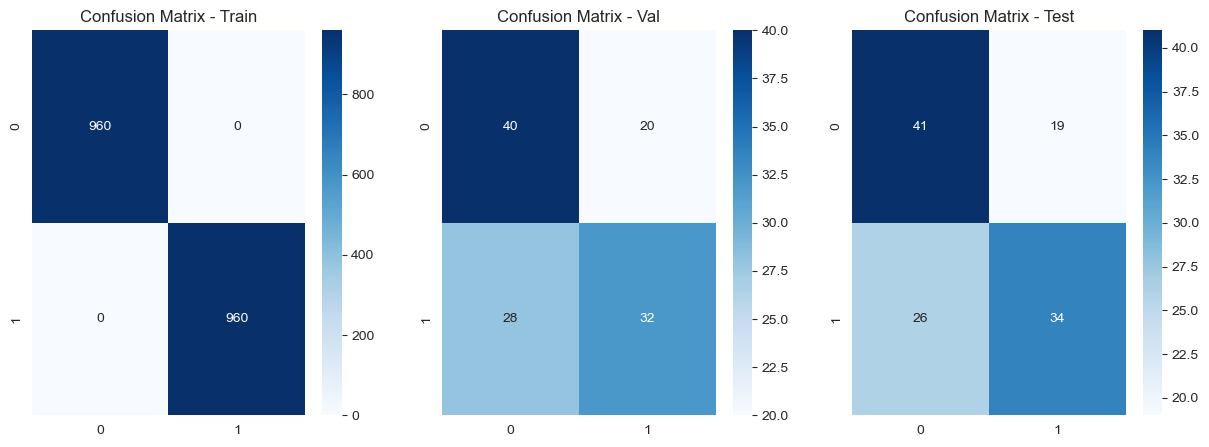

In [ ]:
LR = load('LR.joblib')

# Evaluate the model
report_cm(LR,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)


### SVM

In [37]:
# pattern = 'Minmax'
# X,y = preprocess(df,pattern)
# X , y = random_sample(X,y)
# X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
# X_train, y_train = augment_loop(X_train,y_train,pattern)

In [38]:
# X_flattened_train = X_train.reshape(X_train.shape[0], -1)
# X_flattened_val = X_val.reshape(X_val.shape[0], -1)
# X_flattened_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# Train SVM with RBF kernel
svm_rbf = SVC(kernel = 'rbf')
svm_rbf.fit(X_flattened_train, y_train)
dump(svm_rbf, 'svm_rbf.joblib')

['svm_rbf.joblib']

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       960
           1       0.91      0.89      0.90       960

    accuracy                           0.90      1920
   macro avg       0.90      0.90      0.90      1920
weighted avg       0.90      0.90      0.90      1920

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        60
           1       0.80      0.72      0.75        60

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.77      0.77      0.77       120

              precision    recall  f1-score   support

           0       0.73      0.77      0.75        60
           1       0.75      0.72      0.74        60

    accuracy                           0.74       120
   macro avg       0.74      0.74      0.74       120
weighted avg       0.74      0.74      0.74       120



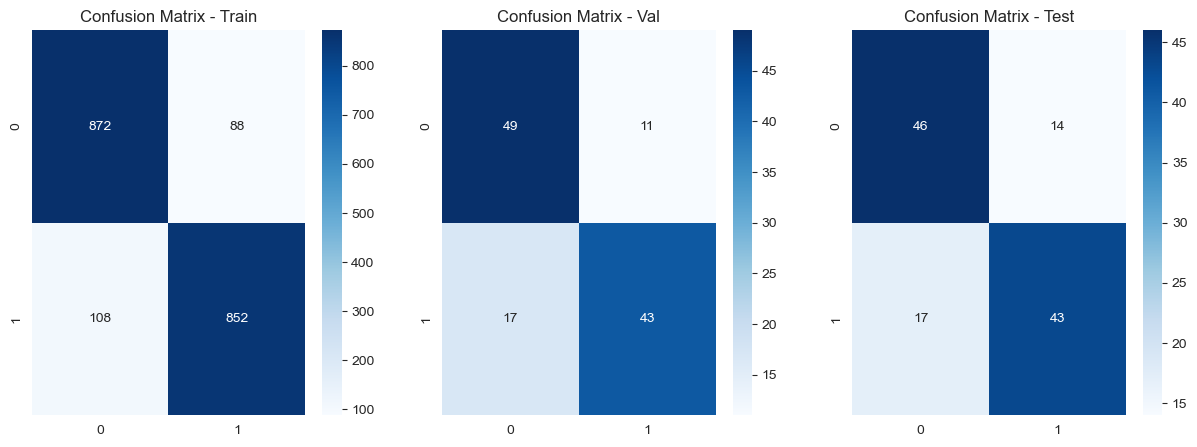

In [ ]:
svm_rbf = load('svm_rbf.joblib')

# Evaluate the model
report_cm(svm_rbf,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)

In [ ]:
# Train SVM with poly kernel
svm_poly = SVC(kernel = 'poly')
svm_poly.fit(X_flattened_train, y_train)
dump(svm_poly, 'svm_poly.joblib')

['svm_poly.joblib']

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       960
           1       0.99      1.00      1.00       960

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920

              precision    recall  f1-score   support

           0       0.60      0.65      0.62        60
           1       0.62      0.57      0.59        60

    accuracy                           0.61       120
   macro avg       0.61      0.61      0.61       120
weighted avg       0.61      0.61      0.61       120

              precision    recall  f1-score   support

           0       0.74      0.75      0.74        60
           1       0.75      0.73      0.74        60

    accuracy                           0.74       120
   macro avg       0.74      0.74      0.74       120
weighted avg       0.74      0.74      0.74       120



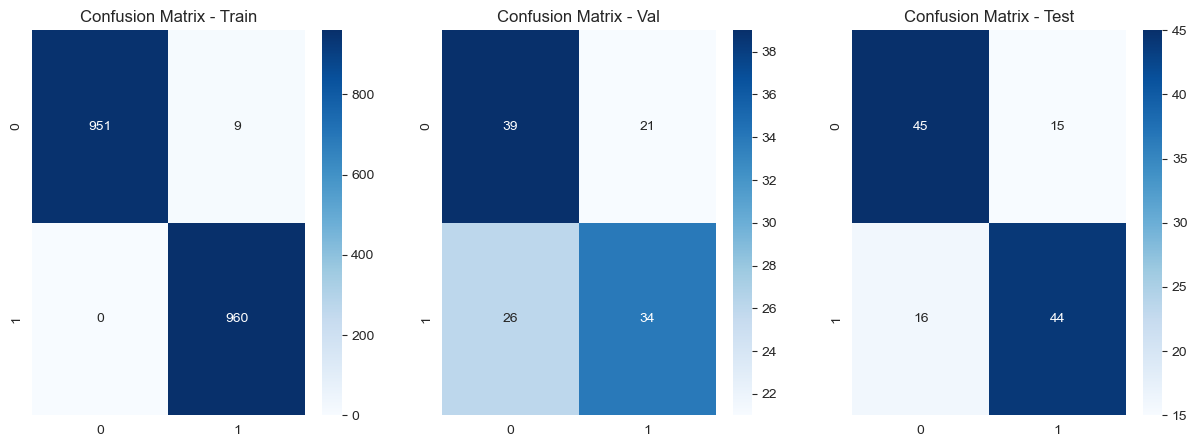

In [ ]:
svm_poly = load('svm_poly.joblib')

# Evaluate the model
report_cm(svm_poly,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)

### KNN

In [ ]:
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [ ]:
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# Function to find the best value of K for KNN
from sklearn.model_selection import cross_val_score
k_range = range(1, 51)
k_error = []
k_best_score = 0
k_best = 1 #Initialize best k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_flattened_train, y_train, cv=6, scoring='accuracy', verbose=1)
    if scores.mean() > k_best_score:
        k_best_score = scores.mean()
        k_best = k
    k_error.append(1 - scores.mean())

# Plot error vs. K value
plt.plot(k_range, k_error)
plt.xlabel('Value of K for KNN')
plt.ylabel('Error')
plt.show()


In [64]:
print(k_best)

In [ ]:
# Train KNN with the best K
k=k_best
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_flattened_train, y_train)
dump(svm_poly, 'knn.joblib')

In [ ]:
knn = load('knn.joblib')
# Evaluate the model
report_cm(knn,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)

### Naive Bayes

In [ ]:
# Preprocess data using Z-score normalization
pattern = 'Zscore'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
# X_train, y_train = augment_loop(X_train,y_train,pattern)
# Data augmentation may not be necessary for Naive Bayes

In [ ]:
# Flatten images for Naive Bayes
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# Train Gaussian Naive Bayes model
NB = GaussianNB()
NB.fit(X_flattened_train, y_train)
dump(NB, 'NB.joblib')

In [ ]:
# Evaluate the model
NB = load('NB.joblib')
report_cm(NB,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)

# Collaboration Block

## GPT

### Image Transformation Techniques

User:
how to flip/rotate/shift images

ChatGPT:
Flipping, rotating, or shifting images can be done using various image processing tools or libraries like Photoshop, GIMP, or programming libraries like Python's OpenCV, PIL (Pillow), or NumPy. Below are step-by-step methods depending on the tool you prefer.

---

### **1. Using Python Libraries**

#### a) **Flip Images**

- **Horizontally (mirror flip):**

  ```python
  from PIL import Image
  img = Image.open("image.jpg")
  flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
  flipped_img.show()
  flipped_img.save("flipped_image.jpg")
  ```

- **Vertically:**

  ```python
  flipped_img = img.transpose(Image.FLIP_TOP_BOTTOM)
  ```

#### b) **Rotate Images**

- Rotate by an angle (e.g., 90, 180 degrees):

  ```python
  rotated_img = img.rotate(90)  # Counter-clockwise rotation
  rotated_img.show()
  ```

#### c) **Shift Images**

To shift an image (translate):

- Using OpenCV:

  ```python
  import cv2
  import numpy as np
  img = cv2.imread("image.jpg")
  rows, cols = img.shape[:2]
  M = np.float32([[1, 0, 50], [0, 1, 100]])  # Shift by 50px right and 100px down
  shifted_img = cv2.warpAffine(img, M, (cols, rows))
  cv2.imshow("Shifted", shifted_img)
  cv2.waitKey(0)
  ```

---

### **2. Using Photoshop**

#### a) **Flip Images**

- Open your image in Photoshop.
- Go to **Edit > Transform > Flip Horizontal** (or Flip Vertical).

#### b) **Rotate Images**

- Go to **Image > Image Rotation** and select an angle (e.g., 90° CW, 180°).

#### c) **Shift Images**

- Use the **Move Tool (V)** and drag the image manually.

---

### **3. Using GIMP**

#### a) **Flip Images**

- Open your image in GIMP.
- Go to **Image > Transform > Flip Horizontally** or **Flip Vertically**.

#### b) **Rotate Images**

- Go to **Image > Transform > Rotate** and choose the desired angle.

#### c) **Shift Images**

- Use the **Move Tool** or the **Offset Tool** (Filters > Map > Offset).

---

### **4. Online Tools**

Websites like **Canva**, **Fotor**, or **Photopea** allow flipping, rotating, and shifting images:

1. Upload your image.
2. Use their tools to apply the desired transformation.

Let me know which tool you'd like detailed guidance on!

### Releasing Storage in Image Analysis

User:
How to release storage when analyzing image data

ChatGPT:
When analyzing image data, especially if you're working with large datasets or processing multiple images, you may encounter memory and storage limitations. Efficiently managing your storage and memory is crucial to maintaining performance and avoiding crashes or slowdowns. Here are several strategies to help you release storage or optimize memory usage during image analysis:

### 1. **Delete Unused Variables**  

If you are working with image data in a programming environment (e.g., Python), make sure to delete or dereference variables that are no longer needed. For example, in Python:

   ```python
del variable_name
   ```

   This releases the memory occupied by the variable, although in Python, garbage collection may still be delayed. Using `gc.collect()` after deleting variables can force garbage collection:

   ```python
import gc
gc.collect()
   ```

### 2. **Use Efficient Image Formats**  

Images can occupy a lot of space depending on their format and resolution. When analyzing large datasets:

   - **Convert to compressed formats**: Convert images to a compressed format like JPEG or PNG (for lossless compression). TIFF files, for example, can be very large and inefficient.
   - **Downsample the images**: If high resolution is not required, downsample the images (reduce the pixel dimensions) before performing the analysis.
   - **Use specialized image formats for analysis**: Formats like `.npz` (for NumPy arrays) or `.h5` (HDF5) are efficient for storing large datasets and can be accessed in chunks.

### 3. **Process Images in Chunks**  

Instead of loading and processing all images at once:

   - **Load and process images in batches or chunks**: Instead of reading an entire directory of images into memory, process them in smaller groups.
   - **Use generators** (if using Python): These allow you to load and process images on-the-fly, releasing memory as soon as a batch is processed.
     Example using a Python generator:

   ```python
def image_batch_generator(image_list, batch_size):
    for i in range(0, len(image_list), batch_size):
        yield image_list[i:i+batch_size]
   ```

### 4. **Avoid Duplicating Data**  

Be cautious when performing operations on image data:

   - **Avoid making unnecessary copies** of image arrays when processing or transforming them.
   - When working with libraries like NumPy or OpenCV, prefer operations that modify the image in place, or be careful with assignments that create copies unintentionally.
     Example in NumPy:

   ```python
image = np.array(image)  # This might create an extra copy
   ```

### 5. **Use Lazy Loading Techniques**  

If you're analyzing a large dataset of images (e.g., in a deep learning context), you can use libraries that implement lazy loading to only load data into memory when necessary:

   - **TensorFlow**: Use `tf.data.Dataset` to load images in batches without keeping everything in memory.
   - **PyTorch**: Use `DataLoader` with `torchvision`'s `ImageFolder` to load images on demand.

### 6. **Optimize Image Preprocessing**  

Many image preprocessing operations (like resizing, normalization, etc.) can be memory-intensive. To optimize:

   - **Perform operations on the fly** rather than saving intermediate results, especially for large datasets.
   - **Use in-place operations** (if the library supports it) to reduce memory usage.

### 7. **Clear Temporary Files**  

If you are saving intermediate results (like processed images, analysis outputs, or temporary files), make sure to clean them up:

   - **Delete temporary images or results** after they are no longer needed.
   - **Use disk caching** for large datasets, where the intermediate data is stored on disk and read when necessary.

### 8. **Use Disk Storage for Large Datasets**  

When working with particularly large datasets:

   - **Store images on disk** and load them into memory only when required.
   - For large image datasets, consider using **database storage solutions** like SQLite, HDF5, or even cloud storage with API access.

### 9. **Offload Image Processing Tasks**  

If you are processing large datasets and your local system's resources are insufficient, consider:

   - **Cloud services** or distributed computing (e.g., AWS, Google Cloud, or Microsoft Azure) to offload the computation and storage.

### 10. **Use Sparse Representations (if applicable)**  

If you are dealing with sparse images (e.g., most of the image data is background or empty), use sparse matrices or compressed storage formats (e.g., `scipy.sparse` matrices) to save space and memory.

### 11. **Use Memory-Mapped Files**  

For very large datasets, consider using memory-mapped files (which allows you to access small sections of the data without loading everything into memory). For example, NumPy has support for memory-mapped arrays:

   ```python
image_data = np.memmap('large_image_data.npy', dtype='float32', mode='r', shape=(1000, 1000))
   ```

### 12. **Optimize Image Loading Libraries**  

Some libraries offer options to manage memory usage during image loading:

   - **OpenCV**: OpenCV’s `imread()` function supports reading images in different color modes. You can read images as grayscale or use reduced precision (e.g., `uint8` instead of `float64`) to reduce memory usage.
   - **Pillow**: The Python Imaging Library (Pillow) allows you to load and manipulate images efficiently.

### 13. **Monitor Memory Usage**  

If you are unsure about memory usage, use tools to monitor your program’s memory consumption:

   - **Python**: Use `psutil` or `memory_profiler` to track memory usage and identify potential bottlenecks.
   - **System tools**: On Linux or macOS, tools like `htop` or `top` can be used to monitor memory usage.

By combining these strategies, you can significantly reduce memory consumption and optimize storage management while analyzing image data, allowing for more efficient processing and analysis.



### Storing Sklearn Models

User:
How to store sklearn models

ChatGPT:
Storing sklearn models can be achieved using serialization, which allows you to save the model to a file and load it later without retraining. Below are the most common ways to store sklearn models:

---

### 1. **Using `joblib` (Recommended for sklearn models)**

`joblib` is specifically optimized for storing large numerical arrays, making it suitable for sklearn models.

**Saving a model:**

```python
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import joblib

# Example: Training a model
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, 'model.joblib')
```

**Loading a model:**

```python
# Load the model
loaded_model = joblib.load('model.joblib')

# Predict with the loaded model
predictions = loaded_model.predict(X_test)
```

---

### 2. **Using `pickle`**

`pickle` is a Python built-in module that can also serialize sklearn models. However, it's generally slower and less optimized than `joblib`.

**Saving a model:**

```python
import pickle

# Save the model
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
```

**Loading a model:**

```python
# Load the model
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
```

---

### 3. **Saving Models in a Portable Format (ONNX or PMML)**

For interoperability between platforms, you might convert sklearn models to formats like ONNX or PMML.

#### Using ONNX:

Install the required library:

```bash
pip install skl2onnx
```

**Convert and save:**

```python
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Define input type
initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]

# Convert the model
onnx_model = convert_sklearn(model, initial_types=initial_type)

# Save the ONNX model
with open("model.onnx", "wb") as file:
    file.write(onnx_model.SerializeToString())
```

**Load and use:**

```python
import onnxruntime as rt

# Load ONNX model
sess = rt.InferenceSession("model.onnx")

# Predict using ONNX
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
predictions = sess.run([label_name], {input_name: X_test.astype(np.float32)})
```

---

### Best Practices

- **File Naming:** Use descriptive names like `random_forest_model.joblib`.
- **Version Control:** Store model metadata (e.g., version, training parameters) to maintain consistency.
- **Environment Tracking:** Document the Python and sklearn versions used to avoid compatibility issues.

By following these methods, you can effectively store and reuse sklearn models for later predictions or deployment.

